# Procesos Gaussianos

## <font color=red>(_La parte amigable_)</font>

El enfoque de regresión con procesos Gaussianos (GPs) es un enfoque no paramétrico, en el sentido de que encuentra una distribución sobre las posibles funciones $f(x)$ que son consistentes con los datos observados.
Al igual que con otros métodos Bayesianos, se comienza con una distribución a priori que es actualizada a medida que se observan nuevos puntos de datos, produciendo una distribución a posterior sobre las funciones.

Para obtener una intuición sobre lo que esto significa, comencemos con una línea de regresión simple definida por un valor de  intersección y un valor de pendiente que logrn el mejor ajuste a los datos.

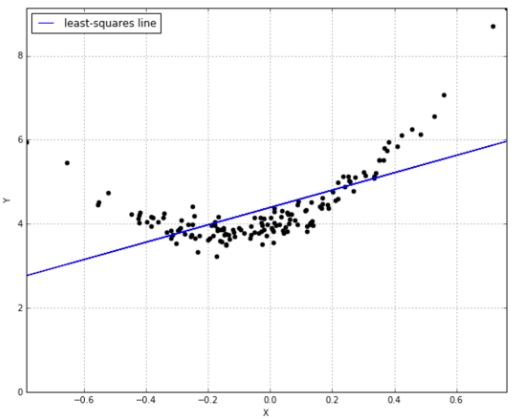

El problema es que esta línea resulta bastante inadecuada para la tarea. En lugar de solo 2 parámetros para la función $\hat{y} = \theta_0+\theta_1x$ parecería que una función cuadrática permitiría aproximar mejor los datos, es decir $\hat{y}=\theta_0+\theta_1x+\theta_2x^2$.

Obviamente ahora tendríamos que aprender 3 parámetros. Pero, ¿qué pasa si no queremos especificar por adelantado cuántos parámetros están involucrados? O quisiéramos considerar todas las funciones posibles que coincidan con nuestros datos, y por lo cual habría cientos (o miles) de parámetros involucrados.

Eso es lo que significa no paramétrico: _no es que no haya parámetros, sino que existen infinitos parámetros._

Pero, por supuesto, necesitamos una suposición a priori acerca de la forma que tienen estas funciones antes de que hayamos visto los datos. A que podrían parecerse?

Bueno, realmente <font color=blue>NO QUEREMOS TODAS LAS FUNCIONES</font>, eso sería una locura. Entonces pongamos algunas restricciones. En primer lugar, solo estamos interesados en un dominio específico; digamos que nuestros valores de $x$ solo van de -5 a 5. Ahora podemos decir que dentro de ese dominio nos gustaría muestrear funciones que producen un resultado cuya media es por ejemplo igual a 0 y que queremos que las funciones no sean demasiado onduladas.

Aquí hay un ejemplo de una función muy ondulada:

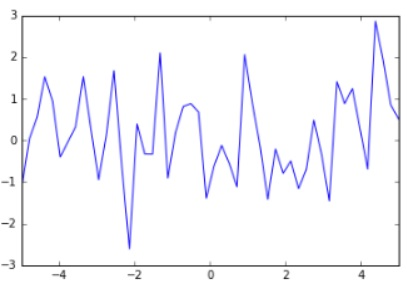

Y aquí hay una función mucho más suave:

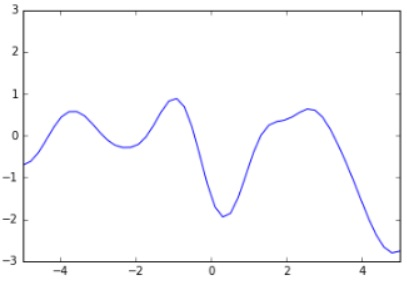

Hay una manera de especificar esa suavidad: usamos una matriz de covarianza para asegurarnos de que los valores que estén cercanos en el espacio de entrada produzcan valores de salida que también estén cercanos. __La matriz de covarianza, junto con la función media para generar el valor esperado de $f(x)$, definen lo que es un GP.__

Ahora podemos definir los puntos en los que se evaluarán nuestras funciones. Escojamos 50 puntos espaciados uniformemente entre -5 y 5. También definimos nuestra función de kernel como la exponencial al cuadrado (también conocido como kernel Gaussiano o función de base radial). Esta función de covarianza calcula la distancia al cuadrado entre los puntos y la convierte en una medida de similitud, controlada por un parámetro de ajuste. Recordemos que estamos asumiendo una media 0 para nuestra distribución a priori.

In [ ]:
import numpy as np
import matplotlib.pyplot as pl

# datos de prueba
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# definir la función kernel
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

param = 0.1
K_ss = kernel(Xtest, Xtest, param)

# descomposición de Cholesky
L = np.linalg.cholesky(K_ss + 1e-15*np.eye(n))
# muestreo de funciones normales para nuestros puntos de prueba,
f_prior = np.dot(L, np.random.normal(size=(n,3)))

# plot de las funciones obtenidas.
pl.plot(Xtest, f_prior)
pl.axis([-5, 5, -3, 3])
pl.title('Tres muestras del GP a priori')
pl.show()

Ahora observaremos algunos datos de prueba. Se ha supuesto que la función real que generó los valores de $y$ de nuestros valores de $x$, pero que es desconocida para nuestro modelo, es la función seno. 

Generamos el resultado en nuestros 5 puntos de muestra a partir de muestrear la distribución a posterior:

In [ ]:
# datos de entrenamiento sin ruido
Xtrain = np.array([-4, -3, -2, -1, 1]).reshape(5,1)
ytrain = np.sin(Xtrain)

# aplicamos la función de kernel a los datos de entrenamiento
K = kernel(Xtrain, Xtrain, param)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

# calculamos la media los puntos de prueba.
K_s = kernel(Xtrain, Xtest, param)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

# calculamos la desviación estándar
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)
# tomamos muestras de la posterior en los puntos de prueba
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))

# y ploteamos
pl.plot(Xtrain, ytrain, 'bs', ms=8)
pl.plot(Xtest, f_post)
pl.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
pl.plot(Xtest, mu, 'r--', lw=2)
pl.axis([-5, 5, -3, 3])
pl.title('Tres muestras del GP a posterior')
pl.show()

Vea cómo los puntos de muestra (los cuadrados azules) han "restringido" el conjunto de funciones posibles: las funciones consideradas a posterior son solo a aquellas que pasan por esos puntos. La línea roja punteada muestra la salida media y el área gris muestra 2 desviaciones estándar de la media. Puede verse como las cosas comienzan a volverse un poco locas entre nuestros puntos de muestra ya que no existe ninguna restricción sobre las funciones hasta que no observemos más datos.

## <font color=red>(_La parte no amigable_)</font>

Describir un procedimiento Bayesiano como "no paramétrico" es algo inapropiado. El primer paso para configurar un modelo Bayesiano es especificar un modelo de probabilidad completo para el problema en cuestión, asignando densidades de probabilidad a cada variable del modelo. Por lo tanto, es difícil especificar un modelo de probabilidad completo sin el uso de funciones de probabilidad, que son paramétricas!!

Los métodos no paramétricos Bayesianos no implican que no haya parámetros, sino que la cantidad de parámetros depende del tamaño del conjunto de datos. Más bien, los modelos no paramétricos bayesianos son infinitamente paramétricos.

### Construyendo modelos a partir de Gaussianas

Qué pasa si elegimos utilizar distribuciones Gaussianas para modelar nuestros datos? Por ejemplo:

$$
p(x \mid \pi, \Sigma) = (2\pi)^{-k/2}|\Sigma|^{-1/2}\exp \left \{  -\frac{1}{2} (x-\mu)^{\prime}\Sigma^{-1}(x-\mu) \right \}
$$

Si bien no parece haber ningún beneficio en hacer esto, porque las distribuciones normales no son distribuciones particularmente flexibles en sí mismas, la adopción de un conjunto de Gaussianas (un vector normal multivariado) nos da una serie de ventajas.

Primero, la distribución marginal de cualquier subconjunto de elementos de una distribución normal multivariada también es una normal:

$$
p(x,y) = \mathcal{N}\left(\left[{
\begin{array}{c}
{\mu_x} \
{\mu_y} \
\end{array}
}\right], \left[{
\begin{array}{cc}
{\Sigma_x} & {\Sigma_{xy}} \\
{\Sigma_{xy}^T} & {\Sigma_y}
\end{array}
}\right]\right)
$$

$$
p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, \Sigma_x)
$$

Además, las distribuciones condicionales de un subconjunto de elementos de una distribución normal multivariada (condicional en los elementos restantes) también son normales:

$$
p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y),
\Sigma_x-\Sigma{xy}\Sigma_y^{-1}\Sigma{xy}^T)
$$

De hecho un GP se define como una colección infinita de variables aleatorias, con cualquier subconjunto marginal de ellas teniendo una distribución Gaussiana. Así, la propiedad de marginación es explícita en su definición.

Otra forma de ver un vector infinito es como una función. Cuando escribimos una función que toma valores continuos como entradas, esencialmente estamos implicando un vector infinito que solo devuelve valores (indexados por las entradas) cuando se solicita la función para hacerlo. De la misma manera, esta noción de una Gaussiana de dimensión infinita representada como una función nos permite trabajar computacionalmente: ya que nunca se nos exige almacenar todos los elementos del GP, solo lo calculamos a pedido.

Por lo tanto, podemos describir un GP como una distribución sobre funciones. Al igual que una distribución normal multivariada se especifica completamente mediante un vector medio y una matriz de covarianza, una GP se especifica completamente mediante una función de media y una función de covarianza:

$$
p(x) \sim \mathcal{GP}(m(x), k(x,x^{\prime}))
$$

Es la propiedad de marginación la que hace factible trabajar con un GP: podemos marginar sobre las infinitas variables en las que no estamos interesados o que no hemos observado. Por ejemplo, una especificación de un GP podría ser:

$$
m(x) =0
$$

$$
k(x,x^{\prime}) = \theta_1\exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)
$$

Aquí, la función de covarianza es una exponencial al cuadrado, para la cual valores de $ x $ y $ x ^ {\prime} $ que están cerca dan como resultado valores de $ k $ más cerca de uno, mientras que los que están más alejados devuelven valores más cerca a cero.

Puede parecer extraño simplemente adoptar la función cero para representar la función media de nuestro GP. Resulta que la mayor parte del aprendizaje con GPs consiste en evaluar la función de covarianza y sus hiperparámetros, por lo que se gana muy poco al especificar una función de media más complicada.

### Muestreo de un proceso Gaussiano

Para hacer más concreta esta noción de una “distribución sobre funciones”, veamos cómo podemos obtener realizaciones de un GP. Lo primero que haremos será obtener muestras del Gp a priori, es decir, antes de que se observen datos.

Lo primero que necesitamos es una función de covarianza (que será la exponencial al cuadrado):

In [ ]:
import numpy as np

# definimos nuestra función de covarianza
def exponential_cov(x, y, params):
    return params[0] * np.exp(-0.5 * params[1] * np.subtract.outer(x, y)**2)

Vamos a generar realizaciones secuencialmente, punto por punto, utilizando la encantadora propiedad condicional de las distribuciones Gaussianas multivariadas:

$$
p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), \Sigma_x-\Sigma{xy}\Sigma_y^{-1}\Sigma{xy}^T)
$$

Y este es el código que lo implementa:

In [ ]:
# definimos la distribución condicional
def conditional(x_new, x, y, params):
 
    B = exponential_cov(x_new, x, params)
    C = exponential_cov(x, x, params)
    A = exponential_cov(x_new, x_new, params)
 
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
 
    return(mu.squeeze(), sigma.squeeze())

Comenzaremos con un GP a priori con hiperparámetros $\theta_0=1$ y $\theta_1=10$. También asumiremos una función media cero, por lo que podemos trazar la banda que representa una desviación estándar de la media:

In [ ]:
%matplotlib inline
import matplotlib.pylab as plt

# ploteamos la distribución a priori
θ = [1, 10]
σ_0 = exponential_cov(0, 0, θ)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=σ_0, capsize=0)
plt.axis([-3, 3, -3, 3]);

Una vez hecho esto seleccionemos un punto de inicio arbitrario para muestrear, digamos $ x = 1 $. Como no hay puntos previos, podemos muestrear desde cualquier Gaussiana no condicional:

In [ ]:
# punto de muestreo arbitrario
x = [1.]
y = [np.random.normal(scale=σ_0)]
y

Ahora podemos actualizar nuestra banda de confianza dado el punto que acabamos de muestrear. Para ello usamos la función de covarianza para generar nuevos intervalos puntuales, pero ahora si condicionales al valor $ [x_0, y_0] $:

In [ ]:
σ_1 = exponential_cov(x, x, θ)

# definimos nuestra función de predicción
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

# y ajustamos la prior a nuestro dato de muestreo
x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, θ, σ_1, y) for i in x_pred]
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro");

Por lo tanto, en función de este punto y de la forma de la función de covarianza que hemos especificado, esencialmente hemos restringido la ubicación probable de todos los puntos siguientes. Probemos con otro:

In [ ]:
# otro dato de muestreo
m, s = conditional([-0.7], x, y, θ)
y2 = np.random.normal(m, s)
y2

Este punto se agrega a la realización anterior y se puede utilizar para actualizar la ubicación del siguiente punto:

In [ ]:
x.append(-0.7)
y.append(y2)
 
σ_2 = exponential_cov(x, x, θ)
predictions = [predict(i, x, exponential_cov, θ, σ_2, y) for i in x_pred]
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro");

Por supuesto, el muestreo secuencial es solo una heurística para demostrar cómo funciona la estructura de la función de covarianza. Podemos muestrear varios puntos a la vez:

In [ ]:
# mas datos de muestreo
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, θ)
y_more = np.random.multivariate_normal(mu, s)
y_more

In [ ]:
x += x_more
y += y_more.tolist()
 
σ_new = exponential_cov(x, x, θ)
predictions = [predict(i, x, exponential_cov, θ, σ_new, y) for i in x_pred]
 
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro");

### Librerías en Python

Aunque es totalmente posible ampliar el código anterior para introducir datos y ajustar un GP a mano, hay una serie de bibliotecas disponibles para especificar y ajustar estos modelos de una manera más automatizada. Tres paquetes que incluyen clases y funciones específicamente diseñadas para el modelado de GP son:

-  __Scikit-learn__
-  __GPflow__
-  __PyMC3__
    
Cada uno de estos paquetes incluye un conjunto de funciones de covarianza que pueden combinarse de manera flexible para describir adecuadamente los patrones de no linealidad en los datos, junto con métodos para ajustar los parámetros de la GP.

### Scikit-learn: ejemplo de modelos GP para diferentes kernels

Este ejemplo ilustra la distribucion a priori y a posteriori de un GP con diferentes kernels:

C:\Users\avila\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-49152.,  40960.]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\avila\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


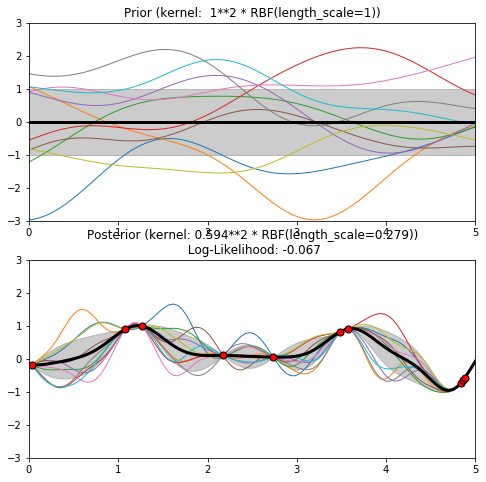

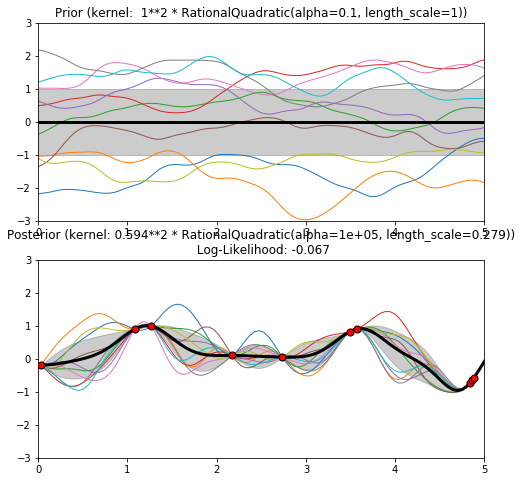

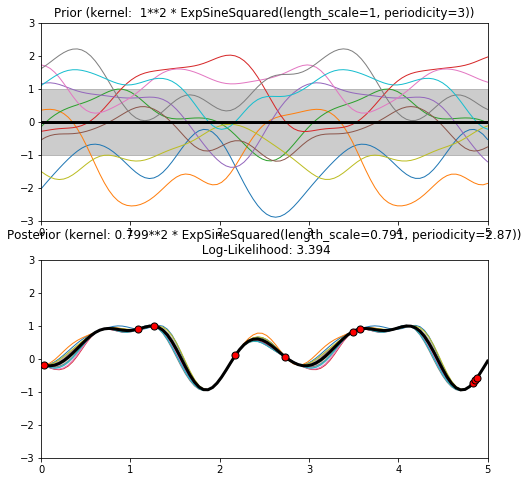

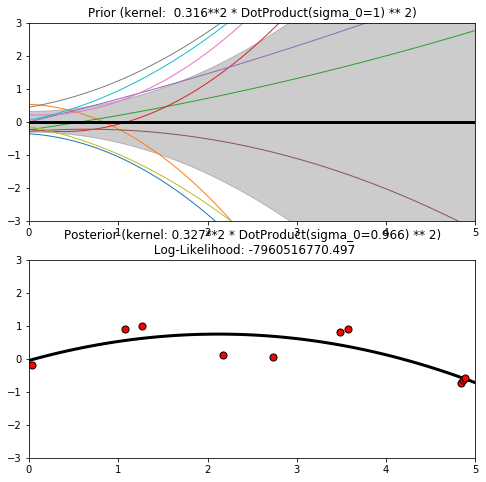

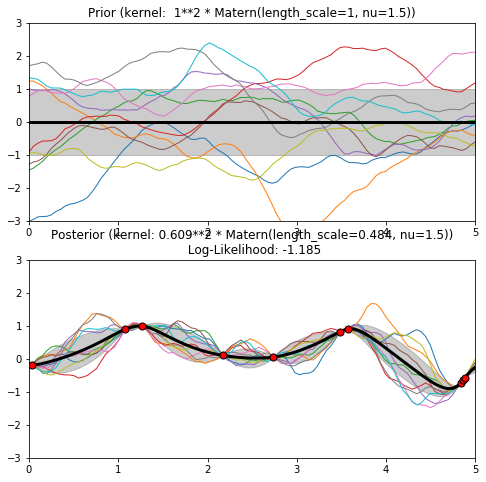

In [2]:
import numpy as np

from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)


kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
           1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5)]

for fig_index, kernel in enumerate(kernels):
    # Specify Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel)

    # Plot prior
    plt.figure(fig_index, figsize=(8, 8))
    plt.subplot(2, 1, 1)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')
    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)

    # Generate data and fit GP
    rng = np.random.RandomState(4)
    X = rng.uniform(0, 5, 10)[:, np.newaxis]
    y = np.sin((X[:, 0] - 2.5) ** 2)
    gp.fit(X, y)

    # Plot posterior
    plt.subplot(2, 1, 2)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')

    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
              % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)),
              fontsize=12)
    plt.tight_layout()

plt.show();

## <font color=red>(_Si quiere amigarse vea_)</font>

Rasmussen, C. E. (2004). Gaussian processes in machine learning. In Advanced lectures on machine learning (pp. 63-71). Springer, Berlin, Heidelberg.